# Modalités

In [1]:
from matplotlib import pyplot as plt
from scipy.stats import binom
import numpy as np
from numba import vectorize, njit
from math import gamma

@njit
def G(x):
    return gamma(x)

# for njit
_ = G(5)

On vas utiliser [numba](https://numba.pydata.org/) qui permet d'obtenir en python des vitesses d'executions proches du C !

# Simulation de lois discrètes

## Bernoulli

In [2]:
@njit
def bernoulli(p, n):
    return np.random.random(n) < p

# for njit
_ = bernoulli(0.5, 5)

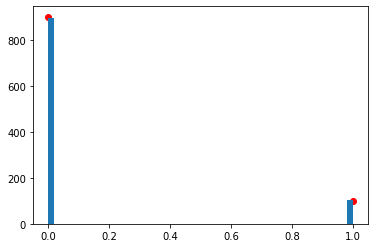

In [3]:
_n, _p = 1000, 0.1

plt.hist(bernoulli(_p, _n).astype(int), bins=50)
plt.scatter([0, 1], [(1-_p)*_n, _p*_n], color='r')
plt.show()

## Binomiale

In [4]:
@njit
def binomiale(p, n, _n):
    return bernoulli(p, (n, _n)).sum(axis=0)

# for njit
_ = binomiale(0.5, 100, 5)

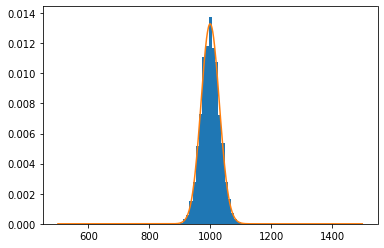

In [5]:
__n, _n, _p = 100_000, 10_000, 0.1

x = np.arange(.05*_n, .15*_n)
f = lambda x : binom.pmf(k=x, n=_n, p=_p)

plt.hist(binomiale(_p, _n, __n), bins=25, density=True)
plt.plot(x, f(x))
plt.show()

## Géométrique (x2)

In [6]:
@njit
def geom1(p, n):
    res = np.zeros(n, dtype=np.int32)
    for i in range(n):
        r = 0
        while not bernoulli(p, 1)[0]:
            r += 1
        res[i] = r
    return res

# for njit
_ = geom1(0.5, 5)

In [7]:
@njit
def geom2(p, n):
    res = np.zeros(n, dtype=np.int32)
    for i in range(n):
        v = np.random.random()
        r = np.int32(0)
        ma = 0
        while v > ma:
            ma += p*(1-p)**r
            r += 1
        res[i] = r
    return res

# for njit
_ = geom2(0.5, 5)

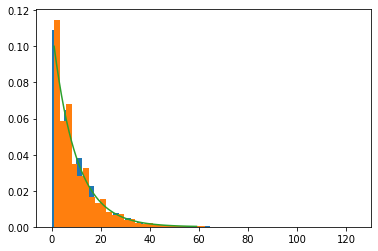

In [8]:
_n, _p = 1_000_000, 0.1

x = np.arange(1, 60)
f = lambda x : _p*(1-_p)**(x-1)

plt.hist(geom1(_p, _n), bins=50, density=True)
plt.hist(geom2(_p, _n), bins=50, density=True)
plt.plot(x, f(x))
plt.show()

# Simulations de lois à densité par inversion de la fonctionde répartition

In [9]:
@njit
def meth_inversion(*args):
    f_inv, n = args[:2]
    return f_inv(np.random.random(n), *args[2:])

# for njit
def identity(x: np.float64) -> np.float64:
    return x
_ = meth_inversion(njit(identity), 1)

/home/n42/.local/lib/python3.8/site-packages/numba/core/utils.py:451: NumbaExperimentalFeatureWarning: First-class function type feature is experimental
  warnings.warn("First-class function type feature is experimental",
<ipython-input-9-f90aae6dd641>:3: NumbaExperimentalFeatureWarning: First-class function type feature is experimental
  f_inv, n = args[:2]
<ipython-input-9-f90aae6dd641>:4: NumbaExperimentalFeatureWarning: First-class function type feature is experimental
  return f_inv(np.random.random(n), *args[2:])


## Exponentielle

In [10]:
@njit
def ex(lam, n):
    def e_inv(y, _l):
        return -np.log(1 - y)/_l
    
    return meth_inversion(e_inv, n, lam)

# for njit
_ = ex(0.5, 1)

<ipython-input-10-148b523c6874>:6: NumbaExperimentalFeatureWarning: First-class function type feature is experimental
  return meth_inversion(e_inv, n, lam)


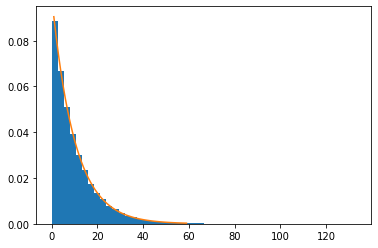

In [11]:
_n, _l = 100_000, 0.1

x = np.arange(1, 60)
f = lambda x: _l * np.exp(-_l*x)

plt.hist(ex(_l, _n), bins=50, density=True)
plt.plot(x, f(x))
plt.show()

## Cauchy

In [12]:
@njit
def cauchy(m, a, n):
    def c_inv(y, a, m):
        return a * np.tan(np.pi * (y - 1/2)) + m
    return meth_inversion(c_inv, n, a, m)

# for njit
_ = cauchy(0, 10, 100)

<ipython-input-12-d274ad26e92b>:5: NumbaExperimentalFeatureWarning: First-class function type feature is experimental
  return meth_inversion(c_inv, n, a, m)


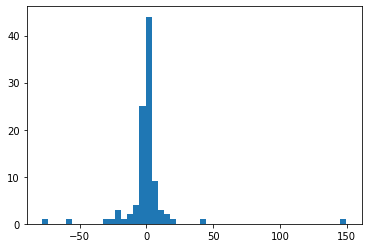

In [13]:
_n, _m, _a = 100, 0, 2

plt.hist(cauchy(_m, _a, _n), bins=50)
plt.show()

## Rayleigh

Par intégration, on obtient :
$$
    y = 1 - e^{-\frac{x^2}{2}}
$$
D'ou:
$$
    x = \sqrt{-2 ln(y - 1)}
$$

In [14]:
@njit
def rayleigh(n):
    def r_inv(y):
        return np.sqrt(-2*np.log(1-y))
    return meth_inversion(r_inv, n)

# for njit
_ = rayleigh(5)

<ipython-input-14-2c549695ea1c>:5: NumbaExperimentalFeatureWarning: First-class function type feature is experimental
  return meth_inversion(r_inv, n)


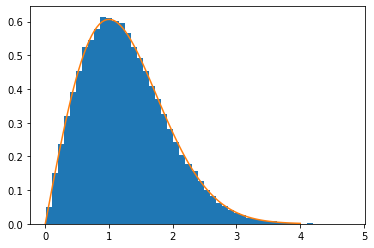

In [15]:
_n = 100_000

x = np.linspace(0,4,100)
f = lambda x : x*np.exp(-x**2/2)

plt.hist(rayleigh(_n), bins=50, density=True)
plt.plot(x, f(x))
plt.show()

# Simulations par la méthode de rejet

In [16]:
@njit
def meth_rejet(f, g, create_y, theta, n):
    res = np.zeros(n)
    
    for i in range(n):
        while True:
            y = create_y()
            u = np.random.random()
            if f(y) > theta * u * g(y):
                break
        res[i] = y
    return res

# for njit
_ = meth_rejet(njit(identity), njit(identity), njit(lambda : 1), 1, 1)

## Loi beta

In [17]:
@njit
def beta22(n):
    theta = 1
    
    def g(x):
        return 1
    _ = g(1)
    
    def f(x):
        a = 2
        b = 2
        return G(a+b)/(G(a) + G(b)) * x**(a-1) * (1-x)**(b-1)
    
    def create_y():
        return np.random.random()
    
    return meth_rejet(f, g, create_y, theta, n)

# for njit
_ = beta22(2)

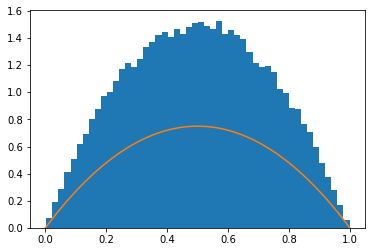

In [18]:
_n = 100_000


x = np.linspace(0, 1 ,100)
a = b = 2
f = lambda x : G(a+b)/(G(a) + G(b)) * x**(a-1) * (1-x)**(b-1)

vals = beta22(_n)
plt.hist(vals, bins=50, density=True)
plt.plot(x, f(x))
plt.show()

Ici `density=True` est dans les choux... ([Cf. GH15603](https://github.com/matplotlib/matplotlib/issues/15603)).


On vas donc tout faire a la main comme des grands.

In [19]:
bi = 50
h = np.histogram(vals, bins=bi)
hx = h[1][:-1]+h[1][1]/2 # center points
hy = bi*h[0]/(2*_n)  # normalize

plt.plot(hx, hy)
plt.plot(x, f(x))
plt.show()

## Loi gamma

In [20]:
@njit
def gamma321(n):
    a = 3/2
    l = 1
    theta = 3**(3/2)/np.sqrt(2*np.pi*np.e)
    
    def g(x):
        _l = 2/3
        return _l * np.exp(-_l*x)
    
    def f(x):
        return (l**a * x**(a-1) * np.exp(-l*x))/G(a)
    
    def create_y():
        return ex(2/3, 1)[0]
    
    return meth_rejet(f, g, create_y, theta, n)

# for njit
_ = gamma321(2)

<ipython-input-20-2f082eadfda9>:17: NumbaExperimentalFeatureWarning: First-class function type feature is experimental
  return meth_rejet(f, g, create_y, theta, n)


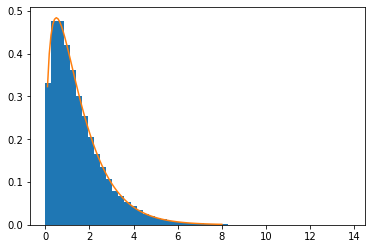

In [21]:
_n = 100_000

a = 1.5
l = 1

def f(x):
    return (l**a * x**(a-1) * np.exp(-l*x))/G(a)

x = np.linspace(0.1, 8, 100)


plt.hist(gamma321(_n), bins=50, density=True)
plt.plot(x, f(x))
plt.show()

# Loi faible des grands nombres

On vas plot la décroissance de la distance entre la moyenne observée et l'esperence théorique pour chaque loi.

On utilise une echelle log comme cela la décroissance en $\dfrac{1}{\sqrt{n}}$ devrai etre linéaire.
On peut le désactiver en commantant les lignes `plt.xscale("log")` et `plt.yscale("log")` et en remplaçant le `logspace` par `linspace`.

Enfin on print la dèrniere valeur ainsi que sa distance.

In [22]:
class TestFunc:
    @classmethod
    def test(cls, n):
        print(f"Testing for {cls.name} :")
        # x = np.linspace(1, n, 100).astype(int)
        x = np.logspace(0, np.log10(n), 100).astype(int)
        y = [np.abs(np.mean(cls.call(i)) - cls.esp) for i in x]
        plt.plot(x,y)
        plt.plot(x,1/np.sqrt(x))
        plt.xscale("log")
        plt.yscale("log")
        plt.show()
        mean = np.mean(cls.call(n))
        print(f"Get mean of {mean:.3f} for {n:.1e} points, expecting {cls.esp:.3f}.")
        print(f"distance = {mean - cls.esp:.3e}.")
        print("\n\n")
    
    @classmethod
    def test_all(cls, n):
        for o in cls.__subclasses__():
            o().test(n)


# Run on :


class Bernoulli(TestFunc):
    name = "Bernoulli(p=0.5)"
    call = lambda n: bernoulli(0.5, n)
    esp = 0.5


class Binomiale(TestFunc):
    name = "Binomiale(p=0.5, n=100)"
    call = lambda n: binomiale(0.5, 100, n)
    esp = 50


class Geom1(TestFunc):
    name = "Géometrique(p=0.5)"
    call = lambda n: geom1(0.5, n)
    esp = (1-0.5)/0.5


class Ex(TestFunc):
    name = "Expoentielle(l=0.5)"
    call = lambda n: ex(0.5, n)
    esp = 2


class Rayleigh(TestFunc):
    name = "Rayleigh"
    call = rayleigh
    esp = np.sqrt(np.pi/2)


class Beta22(TestFunc):
    name = "Beta(a=2,b=2)"
    call = beta22
    esp = 1/2


class Gamma321(TestFunc):
    name = "Gamma(a=3/2,l=1)"
    call = gamma321
    esp = 3/2

Testing for Bernoulli(p=0.5) :


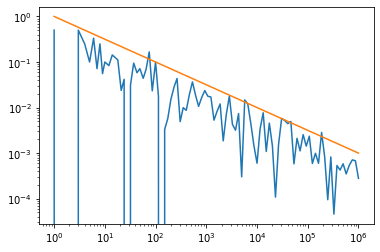

Get mean of 0.500 for 1.0e+06 points, expecting 0.500.
distance = 1.540e-04.



Testing for Binomiale(p=0.5, n=100) :


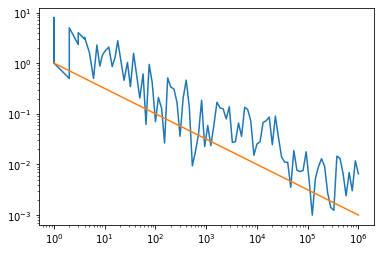

Get mean of 50.003 for 1.0e+06 points, expecting 50.000.
distance = 2.781e-03.



Testing for Géometrique(p=0.5) :


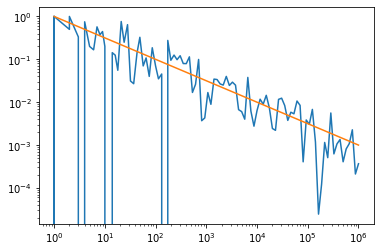

Get mean of 1.001 for 1.0e+06 points, expecting 1.000.
distance = 1.447e-03.



Testing for Expoentielle(l=0.5) :


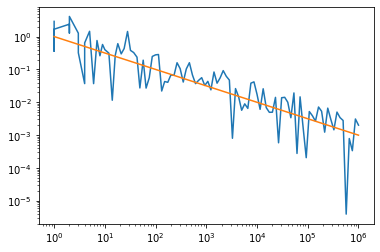

Get mean of 1.999 for 1.0e+06 points, expecting 2.000.
distance = -7.616e-04.



Testing for Rayleigh :


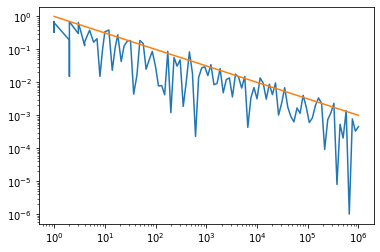

Get mean of 1.253 for 1.0e+06 points, expecting 1.253.
distance = -6.042e-04.



Testing for Beta(a=2,b=2) :


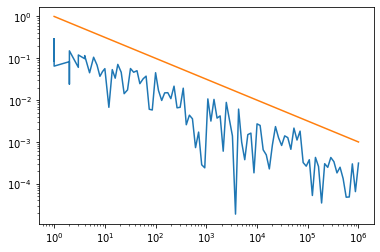

Get mean of 0.500 for 1.0e+06 points, expecting 0.500.
distance = 1.134e-04.



Testing for Gamma(a=3/2,l=1) :


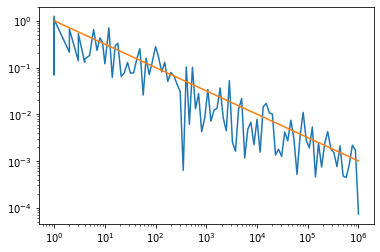

Get mean of 1.501 for 1.0e+06 points, expecting 1.500.
distance = 8.201e-04.





In [23]:
TestFunc.test_all(1_000_000)